In [2]:
from IPython.display import display, Math, Latex

# Libraries you might need
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import seaborn as sns

In [3]:
# You can use this function for plotting raster plots (spikes), or you can use your own defined function
def raster(event_times_list, color='k', t_min= 0., t_max=10., ax=None):
    """
    Creates a raster plot
    Parameters
    ----------
    event_times_list : iterable
                       a list of event time iterables
    color : string
            color of vlines
    Returns
    -------
    ax : an axis containing the raster plot
    https://scimusing.wordpress.com/2013/05/06/making-raster-plots-in-python-with-matplotlib/
    """
    if ax is None:
        ax = plt.gca()
    for ith, trial in enumerate(event_times_list):
        ax.vlines(trial, ith + .5, ith + 1.5, color=color)
    ax.set_ylim(.5, len(event_times_list) + .5)
    ax.set_yticks([])
    ax.set_ylabel('Spike train')
    ax.set_xlim((t_min, t_max))
    ax.set_xlabel('Time [s]')
    return ax

### Homework 2

__1. Generation of inhomogeneous Poisson process__. Consider an inhomogeneous Poisson process with instanteneous firing rate $\lambda: \mathbb{R} \to \mathbb{R}^+$ such that $\lambda(t) = \lambda_{max} \sigma(t)$ with sigmoid function $\sigma(t) = \frac1{1 + e^{-t}}$, where $t$ is measured in seconds, $\lambda$ in Herz [Hz].

In exercise (a) - (d), generate $N = 100$ spike trains for $\lambda_{max} = 100$ Hz. Plot the raster plot, the numeric approximation of the rate and for comparison the analytic rate given in the exercise.
A numeric approximation of the rate $\tilde\lambda$ can be computed by binning the data into 100 bins on the interval $[t_\min, t_\max]$ for each spike train (bin size $\Delta t = \frac{t_\max-t_\min}2$) and computing the number of spikes in all spike trains within the bin, devided by $N$ and the bin size: $\tilde\lambda = \frac{\#spikes}{N \cdot \Delta t}$.

*Hint: Compute the analytical integral of the rate function. Write a function both for the rate function and its integral.*

*Useful integrals for all exercises (including exercise 2)*
\begin{equation*}
\begin{split}
\int \sigma(t) dt
 &= \ln(1 + e^t) + c, \qquad &c \in \mathbb{R} \\
\int \sigma(t)^2 dt
&= \frac1{1 + e^t} + \ln(1 + e^t) + c, \qquad &c \in \mathbb{R}
\end{split}
\end{equation*}

In [175]:
def rate(t, rate_max): 
    return rate_max*(1/(1+np.exp(-t)))

def indefinite_integral(t, rate_max):
    return rate_max*np.log(1+np.exp(t))

def rate_integral(t_min, t_max, rate_max):
    return indefinite_integral(t_max, rate_max) - indefinite_integral(t_min, rate_max)

def rejection_sampling(t_min,t_max,rate_max):
    t_spike = 0
    while True:
        t_sample = np.random.uniform(t_min,t_max)
        u = np.random.uniform(0,1)
        # value 2 gives the envelope function with uniform distribution
        if u <= (rate(t_sample,rate_max)/mu) / (2*(1/(t_max-t_min))):
            t_spike = t_sample
            break

    return t_spike

rate_max = 100
n_trials = 100
t_min = -5
t_max = 5
bins_count = np.linspace(t_min, t_max, 101)
bin_size = bins_count[1] - bins_count[0]

__a) Temporal distribution method:__ As in the lecture: first find number of spikes $k$ by drawing from Poisson distribution with parameter $\mu = \int_{t_\min}^{t_\max} \lambda(t) dt $, and then draw spike times using a density function $\lambda(t)/\mu$. _(2 points)_

*Hint: Choose an appropriate method for drawing from an arbitrary probability density, e.g., rejection sampling.*

In [129]:
# compute ...
mu = rate_integral(t_min,t_max,rate_max)

n_trials = 100
spike_times_all = np.zeros(n_trials,dtype=np.ndarray)
spike_times_1D = []
for n in range(n_trials):
    spike_times = []
    k = np.random.poisson(mu)
    for i in range(k):
        # rejection sampling
        t_spike = rejection_sampling(t_min,t_max,rate_max)
        # save spike times
        spike_times.append(t_spike)
        # 1D spike for numeric approximation
        spike_times_1D.append(t_spike)
    # sort the spikes 
    spike_times_all[n] = np.sort(np.array(spike_times))

# get numeric rate function
numeric_rate, _ = np.histogram(spike_times_1D,bins=101,range=(t_min,t_max))
numeric_rate = numeric_rate/(n_trials*((t_max-t_min)/100))

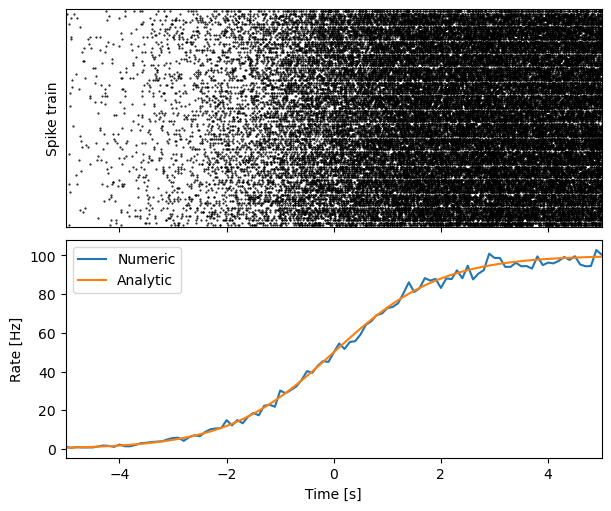

In [130]:
# plot ...
fig, axs = plt.subplots(2,1,figsize=(6, 5), sharex=True, constrained_layout=True)

for n in range(n_trials):
    axs[0].plot(spike_times_all[n],n*np.ones(len(spike_times_all[n])),".",c="k",markersize=1)
    axs[0].set_xlim(-5,5)
    axs[0].set_ylim(-1,100)
    axs[0].set_yticks([])
    axs[0].set_ylabel("Spike train")

axs[1].plot(bins_count,numeric_rate,label="Numeric")
axs[1].plot(bins_count,rate(bins_count,rate_max),label="Analytic")
axs[1].legend()
axs[1].set_ylabel("Rate [Hz]")
axs[1].set_xlabel("Time [s]");

__b) Bernoulli method:__ Discretize time into $m$ bins. For each bin $j = 1, \ldots, m$ draw a sample $k_i$ from a Poisson spike count distribution in that bin ( Poisson distribution with the parameter equal to integral of the $\lambda(t)$ over the bin). Generate a single spike in each bin with $k_i > 0$ drawing its time-stamp from uniform distribution within this bin. Generate rasters and estimated rate for $m = 10, \: 100, \: 1000, \: 10000.$ _(2 points)_

*Note: The bin count for computing a numerical approximation of the rate is still the same as above.*

In [149]:
# compute ...
n_trials = 100

spike_times_all_all = np.zeros(4,dtype=np.ndarray)
numeric_rate_all_all = np.zeros(4,dtype=np.ndarray)

for i, m_bins in enumerate([10,100,1000,10000]):
    dscrt_time = np.linspace(t_min,t_max,m_bins+1)
    
    spike_times_all = np.zeros(n_trials,dtype=np.ndarray)
    spike_times_1D = []
    for n in range(n_trials):
        spike_times = []
        for m in range(m_bins):
            bin_t_min = dscrt_time[m]
            bin_t_max = dscrt_time[m+1]
            
            mu = rate_integral(bin_t_min,bin_t_max,rate_max)
            ki = np.random.poisson(mu)
            if ki > 0:
                # Bernoulli sampling
                t_spike = np.random.uniform(bin_t_min,bin_t_max)
                # save spike times
                spike_times.append(t_spike)
                # 1D spike for numeric approximation
                spike_times_1D.append(t_spike)
        # save spike times for the plot
        spike_times_all[n] = np.array(spike_times)
        
    numeric_rate, _ = np.histogram(spike_times_1D,bins=101,range=(t_min,t_max))
    numeric_rate = numeric_rate/(n_trials*((t_max-t_min)/100))

    spike_times_all_all[i] = spike_times_all
    numeric_rate_all_all[i] = numeric_rate

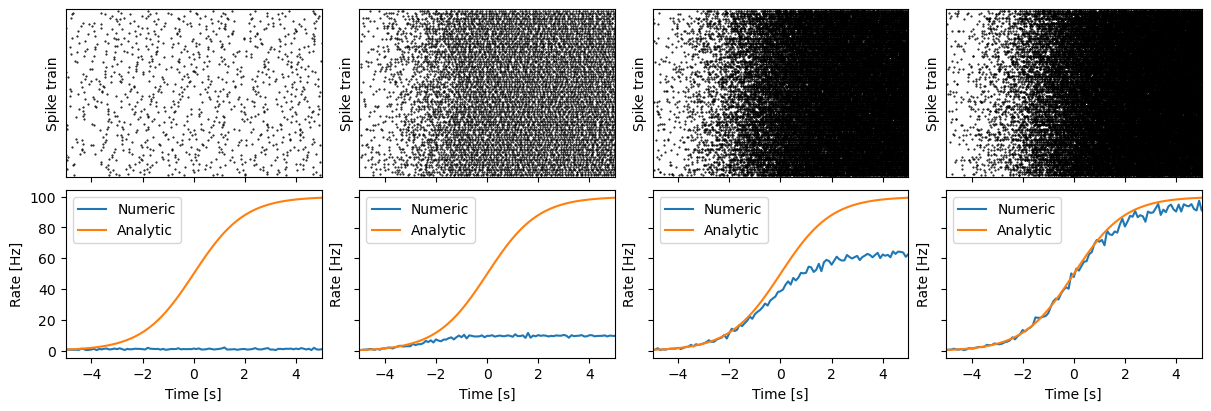

In [151]:
# plot ...
fig, axs = plt.subplots(2,4,figsize=(12, 4), sharex=True, constrained_layout=True)

for m in range(4):
    spike_times_all = spike_times_all_all[m]
    numeric_rate = numeric_rate_all_all[m]
    
    for n in range(n_trials):
        axs[0,m].plot(spike_times_all[n],n*np.ones(len(spike_times_all[n])),".",c="k",markersize=1)
        axs[0,m].set_xlim(-5,5)
        axs[0,m].set_ylim(-1,100)
        axs[0,m].set_yticks([])
        axs[0,m].set_ylabel("Spike train")

    axs[1,m].plot(bins_count,numeric_rate,label="Numeric")
    axs[1,m].plot(bins_count,rate(bins_count,rate_max),label="Analytic")
    axs[1,m].legend()
    axs[1,m].set_ylabel("Rate [Hz]")
    if m > 0:
        axs[1,m].set_yticklabels([])
    axs[1,m].set_xlabel("Time [s]");

__c) Thinning method:__ First generate a spike train from a Poisson process of rate $\lambda_{max}$ and then iterate through all spikes $l = 1, \ldots, k$ and randomly delete them with probability $1 - \lambda(t^\star_l) /\lambda_{max}$, where $t^\star_l$ is a time point of the $l$-th spike (before thinning). _(2 points)_

In [164]:
def poisson_spike_train(tau, t_min, t_max, n_trials):
    spike_times_all = []
    for _ in range(n_trials):
        spike_times = []
        while True:
            dt = np.random.exponential(tau)
            if len(spike_times) == 0:
                spike_times.append(dt+t_min)
            else:
                if spike_times[-1]+dt > t_max:
                    break
                spike_times.append(spike_times[-1]+dt)
        spike_times_all.append(spike_times)
    
    return spike_times_all

In [180]:
# compute...
n_trials = 100
tau = 1/rate_max
spike_times_all = poisson_spike_train(tau, t_min, t_max, n_trials)
thin_spike_times_all = []
thin_spike_times_1D = []
for i, spike_times in enumerate(spike_times_all):
    thin_spike_times = []
    for spike_time in spike_times:
        p = 1-rate(spike_time,rate_max)/rate_max
        if np.random.uniform(0,1) > p:
            thin_spike_times.append(spike_time)
            thin_spike_times_1D.append(spike_time)
    thin_spike_times_all.append(thin_spike_times)
    
numeric_rate, _ = np.histogram(thin_spike_times_1D,bins=101,range=(t_min,t_max))
numeric_rate = numeric_rate/(n_trials*((t_max-t_min)/100))

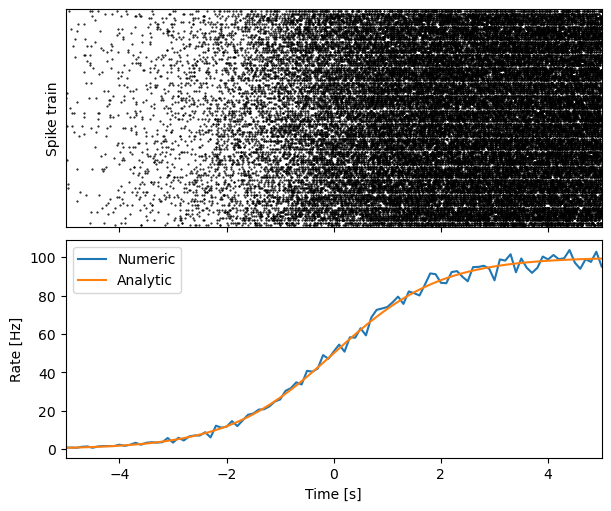

In [181]:
# plot ...
fig, axs = plt.subplots(2,1,figsize=(6, 5), sharex=True, constrained_layout=True)

for n in range(n_trials):
    axs[0].plot(thin_spike_times_all[n],n*np.ones(len(thin_spike_times_all[n])),".",c="k",markersize=1)
    axs[0].set_xlim(-5,5)
    axs[0].set_ylim(-1,100)
    axs[0].set_yticks([])
    axs[0].set_ylabel("Spike train")

axs[1].plot(bins_count,numeric_rate,label="Numeric")
axs[1].plot(bins_count,rate(bins_count,rate_max),label="Analytic")
axs[1].legend()
axs[1].set_ylabel("Rate [Hz]")
axs[1].set_xlabel("Time [s]");

__d) Renewal and time rescaling method:__ Compute $\mu(t) = \int_{t_\min}^t \lambda(s) ds$. Generate a spike train for a homogeneous Poisson process with rate $1$ on an interval $[0,\mu(t_\max)]$ (using inter-spike interval distribution as in the previous homework). Resulting spike times we call $s_l^\star$. We can then find corresponding pre-images $t_l^\star = \mu^{-1}(s_l^\star) \in [t_\min,t_\max].$ _(2 points)_

*Hint: Invert $\mu(t)$ analytically and write a function. Of course, you can use any tools that you want. Remember to write your solution concisely including necessary intermediate steps.*

**Answer:**

\begin{equation*}
\begin{split}
\mu(t) & = \int^t_{t_\min} \lambda(s) ds \\
& = \int^t_{t_\min} \lambda_\max \sigma(s) ds \\
& = \lambda_\max(\ln(1+e^t) - \ln(1+e^{t_\min})) \\
& = \lambda_\max\ln(\frac{1+e^t}{1+e^{t_\min}})
\end{split}
\end{equation*}

To get an inverse function, let's write the function with $y := \mu(t)$ and $x := t$. And also let $a := \lambda_\max$ and $b := 1+e^{t_\min}$
\begin{equation*}
\begin{split}
y &= a\ln(\frac{1+e^x}{b})
\end{split}
\end{equation*}

Now interchange the variables and rewrite the equation w.r.t to $y$
\begin{equation*}
\begin{split}
x & = a\ln(\frac{1+e^y}{b}) \\ 
e^{x/a} & = \frac{1+e^y}{b} \\
be^{x/a}-1 & = e^y \\
y & = \ln(be^{x/a}-1)
\end{split}
\end{equation*}

Then we have the $\mu^{-1}(s)$
\begin{equation*}
\begin{split}
\mu^{-1}(s) & = \ln((1+e^{t_\min})e^{s/\lambda_\max}-1)
\end{split}
\end{equation*}

In [186]:
def inverse_integral(s, t_min, t_max, rate_max):
    b = 1+np.exp(t_min)
    return np.log(b*np.exp(s/rate_max)-1)

def _mu(t, t_min, rate_max):
    b = 1+np.exp(t_min)
    return rate_max*np.log((1+np.exp(t))/b)

In [187]:
# compute ...
renew_inverse_spike_times_all = poisson_spike_train(1, 0, _mu(t_max, t_min, rate_max), n_trials)
renew_spike_times_all = []
renew_spike_times_1D = []
for n in range(n_trials):
    renew_inverse_spike_times = renew_inverse_spike_times_all[n]
    renew_spike_times = []
    for renew_inverse_spike_time in renew_inverse_spike_times:
        renew_spike_time = inverse_integral(renew_inverse_spike_time, t_min, t_max, rate_max)
        renew_spike_times.append(renew_spike_time)
        renew_spike_times_1D.append(renew_spike_time)
        
    renew_spike_times_all.append(renew_spike_times)

numeric_rate, _ = np.histogram(renew_spike_times_1D,bins=101,range=(t_min,t_max))
numeric_rate = numeric_rate/(n_trials*((t_max-t_min)/100))

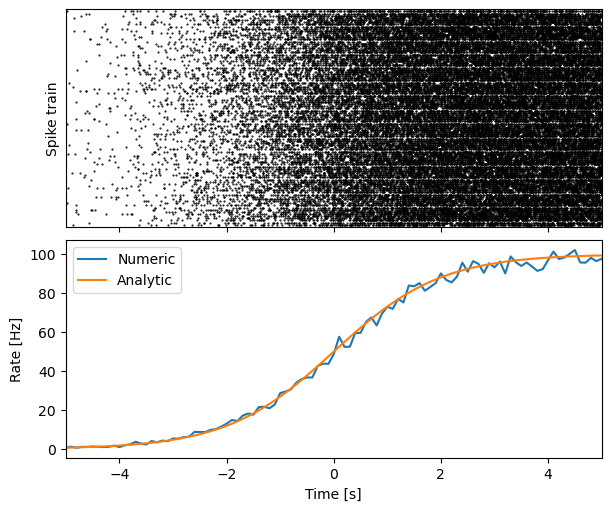

In [188]:
# plot ...
fig, axs = plt.subplots(2,1,figsize=(6, 5), sharex=True, constrained_layout=True)

for n in range(n_trials):
    axs[0].plot(renew_spike_times_all[n],n*np.ones(len(renew_spike_times_all[n])),".",c="k",markersize=1)
    axs[0].set_xlim(-5,5)
    axs[0].set_ylim(-1,100)
    axs[0].set_yticks([])
    axs[0].set_ylabel("Spike train")

axs[1].plot(bins_count,numeric_rate,label="Numeric")
axs[1].plot(bins_count,rate(bins_count,rate_max),label="Analytic")
axs[1].legend()
axs[1].set_ylabel("Rate [Hz]")
axs[1].set_xlabel("Time [s]");

__2. Variance of the firing rate a)__. Determine the variance of the firing rate (across the bins) using $b = 10, \: 50, \:100$ bins from spike trains generated by method 1.a) using the law of total variance  _(2 points)_

**Answer:**

\begin{equation*}
\begin{split}
Var[\lambda_i] = \frac{Var(N_i)}{\Delta t^2} - \frac{N}{T\Delta t}
\end{split}
\end{equation*}

In [217]:
# compute the variance
def firing_rate_variance(spike_counts, b, t_min, t_max):
    dt = (t_max-t_min) / b
    T = t_max - t_min
    var_spike_count = np.var(spike_counts)

    return var_spike_count/dt**2 - np.sum(spike_counts)/(T*dt)

def spike_count_variance(spike_counts, b, t_min, t_max):
    numeric_rate = spike_counts

In [228]:
# compute and print my solution
mu = rate_integral(t_min,t_max,rate_max)

n_trials = 100
spike_times_all = np.zeros(n_trials,dtype=np.ndarray)
spike_times_1D = []
for n in range(n_trials):
    spike_times = []
    k = np.random.poisson(mu)
    for i in range(k):
        # rejection sampling
        t_spike = rejection_sampling(t_min,t_max,rate_max)
        # save spike times
        spike_times.append(t_spike)
        # 1D spike for numeric approximation
        spike_times_1D.append(t_spike)
    # sort the spikes 
    spike_times_all[n] = np.sort(np.array(spike_times))

b = 10
print(b)
spike_density_10, _ = np.histogram(spike_times_1D,bins=b+1,range=(t_min,t_max),density=True)
spike_counts_10, _ = np.histogram(spike_times_1D,bins=b+1,range=(t_min,t_max))
spike_counts_10 = spike_counts_10 / n_trials
print(np.sum(spike_counts_10*spike_density_10*(t_max-t_min)/b))
print(np.var(spike_counts_10))
var_firing_rate = firing_rate_variance(spike_counts_10, b, t_min, t_max)
print(var_firing_rate)

b = 50
print(b)
spike_counts_50, _ = np.histogram(spike_times_1D,bins=b+1,range=(t_min,t_max))
spike_counts_50 = spike_counts_50/n_trials
print(np.mean(spike_counts_50)*b)
print(np.var(spike_counts_50))
var_firing_rate = firing_rate_variance(spike_counts_50, b, t_min, t_max)
print(var_firing_rate)

b = 100
print(b)
spike_counts_100, _ = np.histogram(spike_times_1D,bins=b+1,range=(t_min,t_max))
spike_counts_100 = spike_counts_100/n_trials
print(np.mean(spike_counts_100)*b)
print(np.var(spike_counts_100))
var_firing_rate = firing_rate_variance(spike_counts_100, b, t_min, t_max)
print(var_firing_rate)

10
79.53836185504917
1223.7766148760331
1173.9666148760332
50
488.33333333333326
57.42583006535949
1186.595751633987
100
493.1683168316831
14.665037761003825
968.4037761003824


__2. Variance of the firing rate b)__. Compare results from 2.a) with analytical variance of the rate. To compute the analytical variance use the true formula for the time-dependent rate  $\lambda(t) = \lambda_{max} \sigma(t)$ and treat it as a random variable for the time $t$ uniformly distributed in $[t_\min,t_\max]$. \\
_(2 points)_

**Answer:**

...

So variance is
\begin{equation*}
\begin{split}
Var(\lambda)
&= ... \\
&\approx 15134
\end{split}
\end{equation*}